# Swimming Mammal Recognition

I will try and buil a ML algorithm that is capable of identifying almost 28k unique individual marine mammals belonging to 30 species.

Dataset can be downloaded from [here](https://www.kaggle.com/bdsaglam/happy-whale-512?select=sample_submission.csv). This is the "simplified version" of the [original dataset](https://www.kaggle.com/c/happy-whale-and-dolphin/data) in that all the figures have the same size (512x512) -- if smaller they have been padded. 

The files are already divided into train and test folders, although there is no `species` label associated to each test image. *** Review this ***

My idea is:
1. train a non-pretrained resnet34 network from scratches (`xresnet34` in the fastai libraries);
1. train a pretrained resnet34 network;
1. compare the results and comment on that.

## Download the dataset from kaggle

First install the kaggle extension:

In [1]:
! pip install kaggle

Create a folder `./kaggle` and move the `.json` file associated to your kaggle account, and give it reading permission:

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Download the dataset using the following command:

In [3]:
! kaggle datasets download bdsaglam/happy-whale-512

100% 1.80G/1.80G [00:18<00:00, 98.6MB/s]
100% 1.80G/1.80G [00:18<00:00, 105MB/s] 


Unzip the dataset file:

In [4]:
! unzip happy-whale-512.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: train_images/e7bc059aee4278.jpg  
  inflating: train_images/e7bdb883f8c192.jpg  
  inflating: train_images/e7be23bf6653c8.jpg  
  inflating: train_images/e7be96514ee807.jpg  
  inflating: train_images/e7c0df0b76833c.jpg  
  inflating: train_images/e7c17317474d34.jpg  
  inflating: train_images/e7c36c00dd51af.jpg  
  inflating: train_images/e7c7fef8d408ca.jpg  
  inflating: train_images/e7ca953a8b7a2e.jpg  
  inflating: train_images/e7d1574453ba7f.jpg  
  inflating: train_images/e7d1cdb2fdf583.jpg  
  inflating: train_images/e7d2503911061d.jpg  
  inflating: train_images/e7d2b70e19ca38.jpg  
  inflating: train_images/e7d4d607c23594.jpg  
  inflating: train_images/e7d925d05331af.jpg  
  inflating: train_images/e7da024ea3cc0b.jpg  
  inflating: train_images/e7dc4488aad32e.jpg  
  inflating: train_images/e7dd864353d346.jpg  
  inflating: train_images/e7ddeee28f524b.jpg  
  inflating: train_images/e7e07a795435a1.jpg  
  inflatin

## Initial imports and setup

Upgrade fastai on colab (this noteboook worked with fastai version 2.5.3)

In [5]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

     |████████████████████████████████| 197 kB 5.4 MB/s 
     |████████████████████████████████| 60 kB 6.5 MB/s 


In [6]:
import fastai
fastai.__version__
# '2.5.3'

'2.6.3'

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from fastai.vision.all import *
from fastai.callback import *
from fastai.metrics import error_rate
import pandas as pd
import os, csv

Setting some variables:

In [9]:
item_size = 480
tfm_size = 224
bs = 64 #same as default, so I am not using it -- atm

## Creating dataloader

Defining all the paths and reading the csv file containing the labels (i.e. the mammal species) associated to each image.

In [10]:
path = '/content'
path_images = '/content/train_images'
#os.listdir(path_images)

path_labels = '/content/train.csv'
#* Read csv file using pandas
df = pd.read_csv(path_labels)
#df.head	#* printing datafile names

Creating the dictionary with the structure:

```
	image_name: species
```

and the function to retrieve the species starting from the filename.

In [11]:
species = {}
with open(path_labels) as file:
	reader = csv.DictReader(file)
	for row in reader:
		species[row['image']] = row['species']

def label_func(fname):
    return species[str(fname).split('/')[-1]]

Given our dataset we want to create a dataloader for it, that splits the dataset into a *test* and a *training* set. Images are resized to `item_size`x`item_size`, and are padded if necessary (should not, since the images I refer to in the link above are all larger, 512x512).

I load the images from the `train_images` folder, using the labels loaded from `train.csv`:

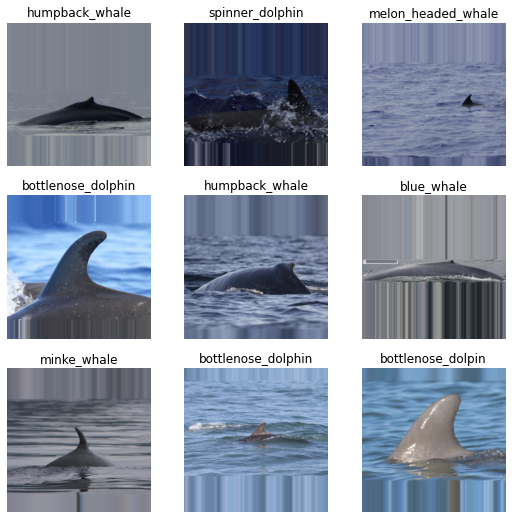

In [12]:
dls = ImageDataLoaders.from_df(df, 
	path,
	folder = 'train_images',
	item_tfms=Resize(item_size,method=ResizeMethod.Pad),
	batch_tfms=Normalize.from_stats(*imagenet_stats))

dls.show_batch()

In [13]:
fnames = get_image_files(path_images)
fnames[:10]

(#10) [Path('/content/train_images/59df839426c235.jpg'),Path('/content/train_images/7f699e04dc8db2.jpg'),Path('/content/train_images/01b371886547bd.jpg'),Path('/content/train_images/2fc774f1b73458.jpg'),Path('/content/train_images/420ad4dd4491c5.jpg'),Path('/content/train_images/9a69ee432b9afc.jpg'),Path('/content/train_images/677f999a25063c.jpg'),Path('/content/train_images/1791cef321825b.jpg'),Path('/content/train_images/70074692c30882.jpg'),Path('/content/train_images/e3dc4dbdfc0d1e.jpg')]

I now create the DataBlock, i.e. how to assemble data as follows:

1. splitting the blocks into an image block and a category block;
1. grab the images with the built-in feature `get_image_files`;
1. grab the species associated to each image using the function I have defined above `label_func`;
1. transform the images, resizing them to 64x64 and padding them;
1. splitting the images into a validation and training set, setting myself a `seed` for the random number generator;
1. normalising the images within the batch.

Splitting the dataset into a validation and training set with the seed for the random number is a choice I made based on the fact that I want both parts of the training to be done over the same pictures, so to reduce the bias in my attempt to compare the two approaches.

In [14]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
	get_items = get_image_files,
	get_y = label_func,
	item_tfms=Resize(item_size,method=ResizeMethod.Pad),
	splitter=RandomSplitter(valid_pct=.1, seed=42),
	batch_tfms=[*aug_transforms(size=tfm_size, max_warp=0), Normalize.from_stats(*imagenet_stats)]
	)


In [15]:
dsets = dblock.datasets(path_images)
no_species = len(dsets.vocab) # returns the total number of species

#dsets.train[:5]

We don't need to do anything else since the images are already of size 512x512 and if smaller, these are patched. Moreover, the dataset is made of figures that have already been rotated, cropped, and "cleaned up", so there is not much left to do.

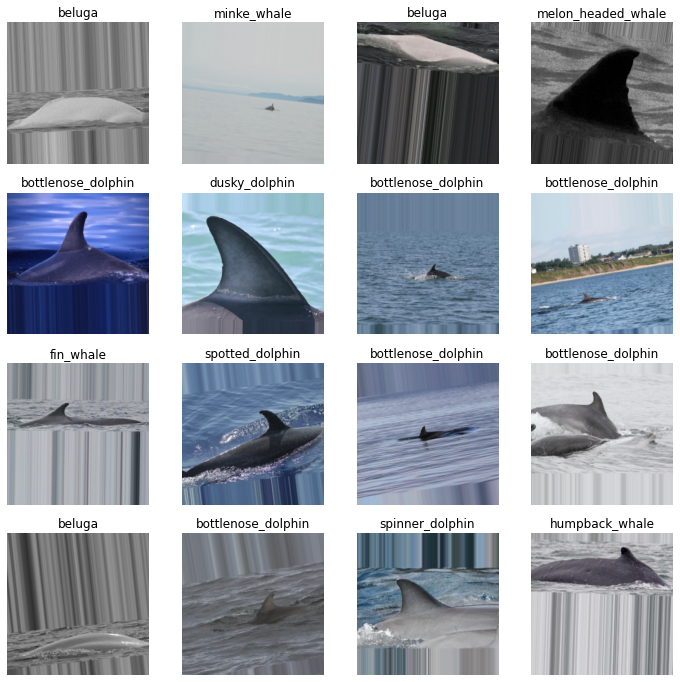

In [16]:
dls = dblock.dataloaders(path_images)
dls.show_batch(max_n=16)

## Start the learning process

I want to train a model from scratch since there is no such a pre-trained NN.

I might use a CNN learner with the `pretrained` option set to `False`, or otherwise I can use a set of resnet models that have "all the tricks from modern research incorporated".

I opted for the latter option, using a `xresnet34` models, specifying the number of classes we expect to see as a result, and nothing else.

### xresnet34

I define here the `xresnet34` model to be used, specifying the number of classes (`no_species`) and the fact that I want it to be non-pretrained.



In [17]:
netw34_subopt = xresnet34(n_out=no_species, pretrained = False)
# netw34_subopt[0]

Launching the learning process. In order to do so, I specify the metrics, `accuracy` and `error_rate`.

In [18]:
learn34_subopt = Learner(dls,model = netw34_subopt, metrics =[accuracy,error_rate])

I then take a look at the suggested learning rate, to find:

SuggestedLRs(valley=0.002511886414140463)

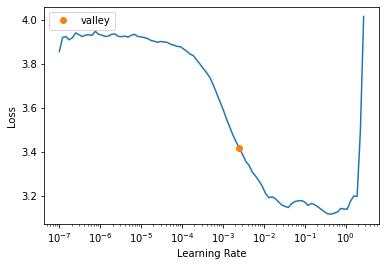

In [20]:
learn34_subopt.lr_find()
# SuggestedLRs(valley=0.0020892962347716093)

I now launch the `fit_one_cycle` procedure with the optimal lr obtained in the previous cell with `lr_find()`:

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.130909,1.184696,0.638644,0.361356,13:16
1,0.701074,0.714910,0.772095,0.227905,12:42
2,0.457935,0.431168,0.861650,0.138350,13:21
3,0.261489,0.299497,0.901626,0.098374,13:25
4,0.201724,0.217945,0.930433,0.069567,13:48


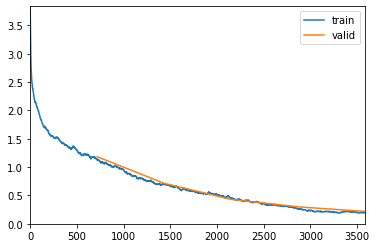

In [21]:
learn34_subopt.fit_one_cycle(5,2e-2,cbs=[ShowGraphCallback()])

Saving the model first:

In [27]:
learn34_subopt.save('dorsal_xresnet34_v2') # v1 I have produced using my laptop, and was not really satisfactory

Path('models/dorsal_xresnet34_v3.pth')

Checking the results:

In [22]:
learn34_subopt.summary()

XResNet (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2d                                    864        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                             

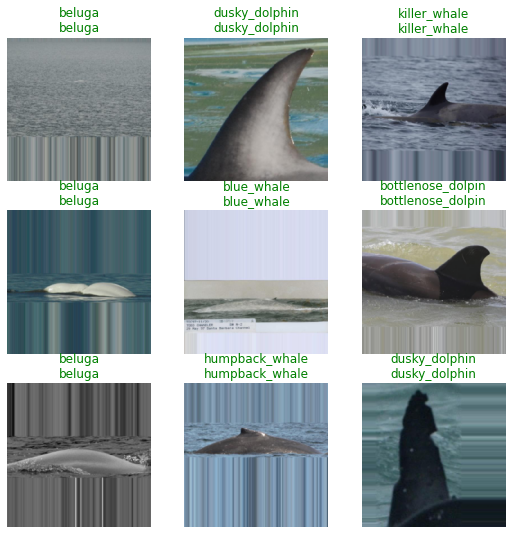

In [23]:
learn34_subopt.show_results()

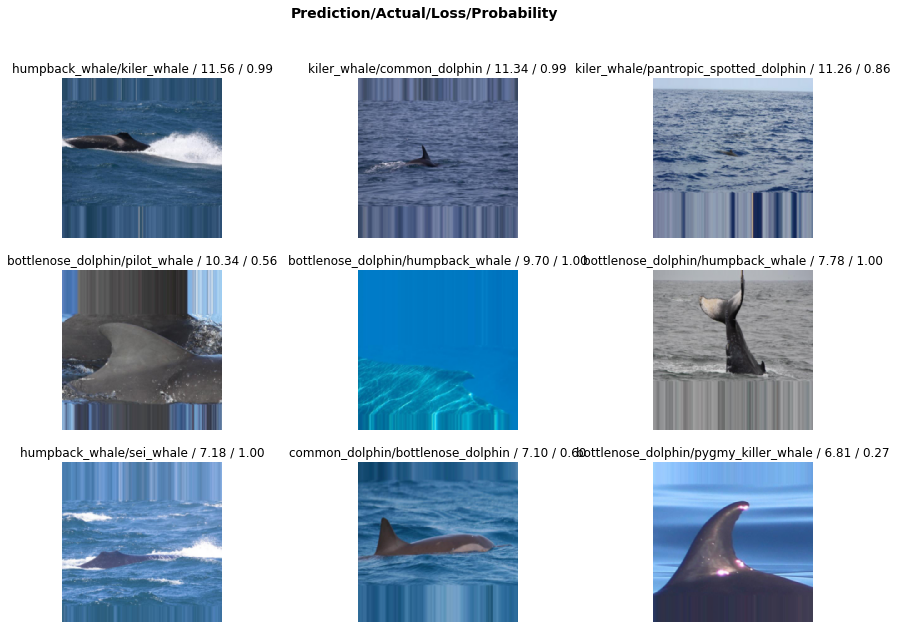

In [24]:
interp34 = ClassificationInterpretation.from_learner(learn34_subopt)
interp34.plot_top_losses(9,figsize=(15,10)) # Bug in Fastai here -- only plots one.

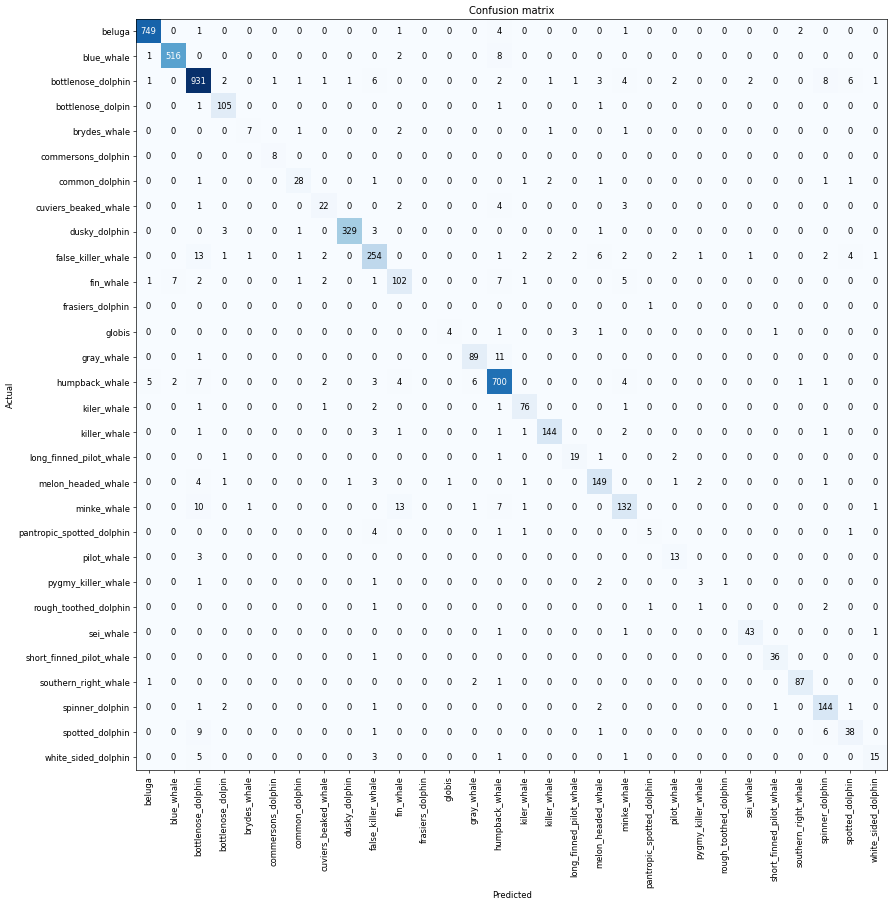

In [25]:
interp34.plot_confusion_matrix(figsize=(15,15), dpi=60)

In [26]:
interp34.most_confused(min_val=5)

[('false_killer_whale', 'bottlenose_dolphin', 13),
 ('minke_whale', 'fin_whale', 13),
 ('gray_whale', 'humpback_whale', 11),
 ('minke_whale', 'bottlenose_dolphin', 10),
 ('spotted_dolphin', 'bottlenose_dolphin', 9),
 ('blue_whale', 'humpback_whale', 8),
 ('bottlenose_dolphin', 'spinner_dolphin', 8),
 ('fin_whale', 'blue_whale', 7),
 ('fin_whale', 'humpback_whale', 7),
 ('humpback_whale', 'bottlenose_dolphin', 7),
 ('minke_whale', 'humpback_whale', 7),
 ('bottlenose_dolphin', 'false_killer_whale', 6),
 ('bottlenose_dolphin', 'spotted_dolphin', 6),
 ('false_killer_whale', 'melon_headed_whale', 6),
 ('humpback_whale', 'gray_whale', 6),
 ('spotted_dolphin', 'spinner_dolphin', 6),
 ('fin_whale', 'minke_whale', 5),
 ('humpback_whale', 'beluga', 5),
 ('white_sided_dolphin', 'bottlenose_dolphin', 5)]

The results are quite good: the algorithm can recognise the species with an accuracy over 90%. Also the confusion matrix looks very diagonal.

## Pretrained `resnet34`

As an alternative, I  used the pre-trained `resnet34` learner, in order to see whether there is an improvement in the ability of guessing the species.

I basically follow the same steps as above.

In [28]:
dblock_pretrained = DataBlock(blocks = (ImageBlock, CategoryBlock),
	get_items = get_image_files,
	get_y = label_func,
	item_tfms=Resize(item_size,method=ResizeMethod.Pad),
	splitter=RandomSplitter(valid_pct=.1, seed=42),
	batch_tfms=[*aug_transforms(size=tfm_size, max_warp=0), Normalize.from_stats(*imagenet_stats)]
	# batch_tfms=Normalize.from_stats(*imagenet_stats)
	)


In [29]:
dls_pretrained = dblock_pretrained.dataloaders(
	path_images
	)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0005754399462603033)

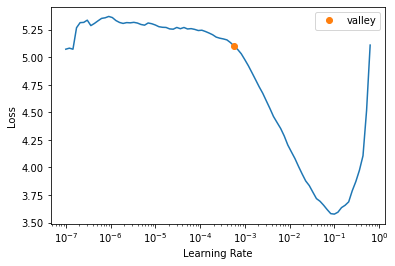

In [30]:
learn_pretrained = cnn_learner(dls_pretrained, resnet34, metrics=[accuracy,error_rate])
learn_pretrained.lr_find()
# SuggestedLRs(valley=0.001737800776027143)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.773020,0.782517,0.775230,0.224770,12:03
1,0.452069,0.333382,0.893984,0.106016,11:45
2,0.280229,0.197807,0.938076,0.061924,11:44


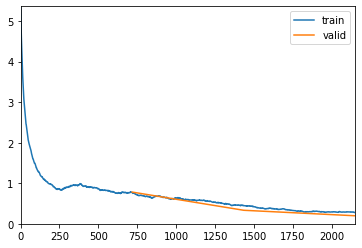

In [31]:
learn_pretrained.fit_one_cycle(3,2e-2,cbs=[ShowGraphCallback()])

Unfreezing and fine-tuning:

In [32]:
learn_pretrained.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.202433,1.073605,0.681756,0.318244,12:13
1,0.621119,0.463638,0.853420,0.146580,12:05


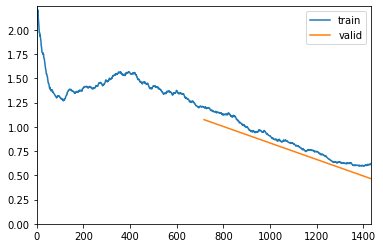

In [33]:
learn_pretrained.fit_one_cycle(2, 3e-2,cbs=[ShowGraphCallback()])

Saving the model:



In [34]:
learn_pretrained.save('dorsal_pretrained_resnet34_v3')

Path('models/dorsal_pretrained_resnet34_v2.pth')

That looks worse than the unfrozen case. My suspect is that this happens due to the fact that some individuals have marks on their back/fin. Such characteristic signs are very well captured and recognised by the pretrained model, that as a consequence is very reliable. On the other hand, when the `unfreeze` is operated, this ability to recognise the characteristic signs is lost, hence the drop down in the accuracy. This phenomenon is worth investigating -- sadly, I have no time (at least not enough, at the moment) but I will work on it in a non-better specified future. 

Looking at the summary and the results:

In [35]:
learn_pretrained.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

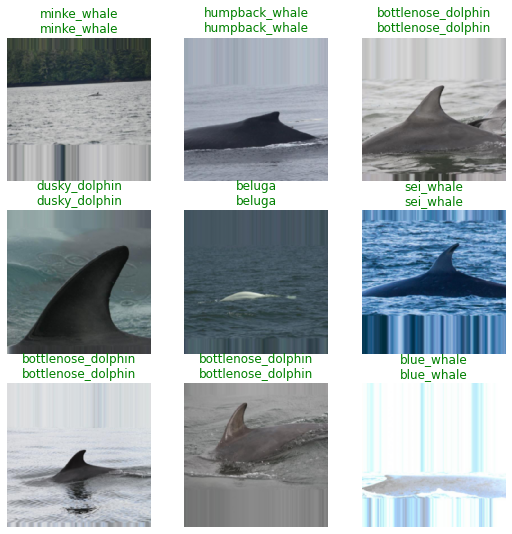

In [36]:
learn_pretrained.show_results()

Getting the top losses, confusion matrix and most confused elements:

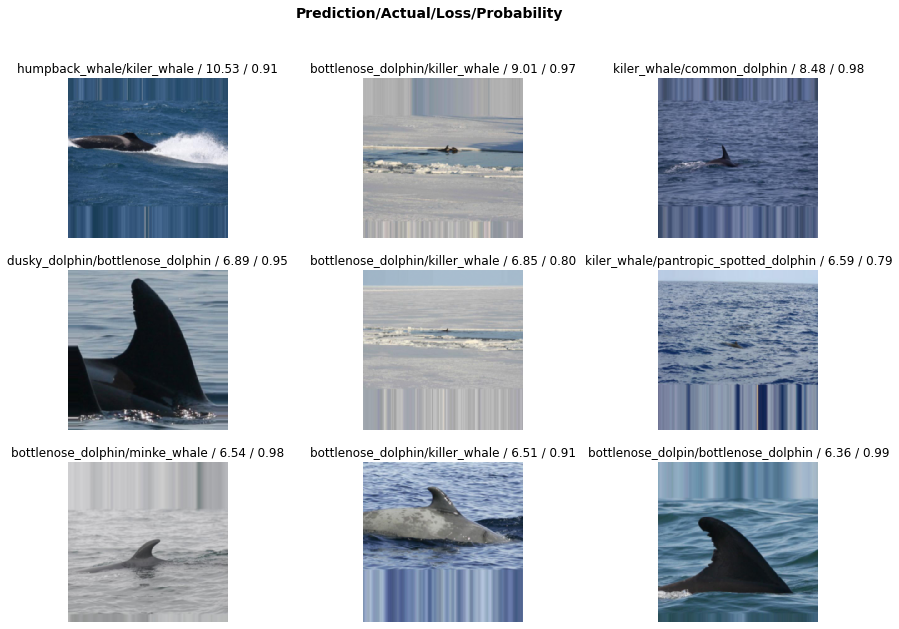

In [37]:
interp_pretrained = ClassificationInterpretation.from_learner(learn_pretrained)
interp_pretrained.plot_top_losses(9,figsize=(15,10))

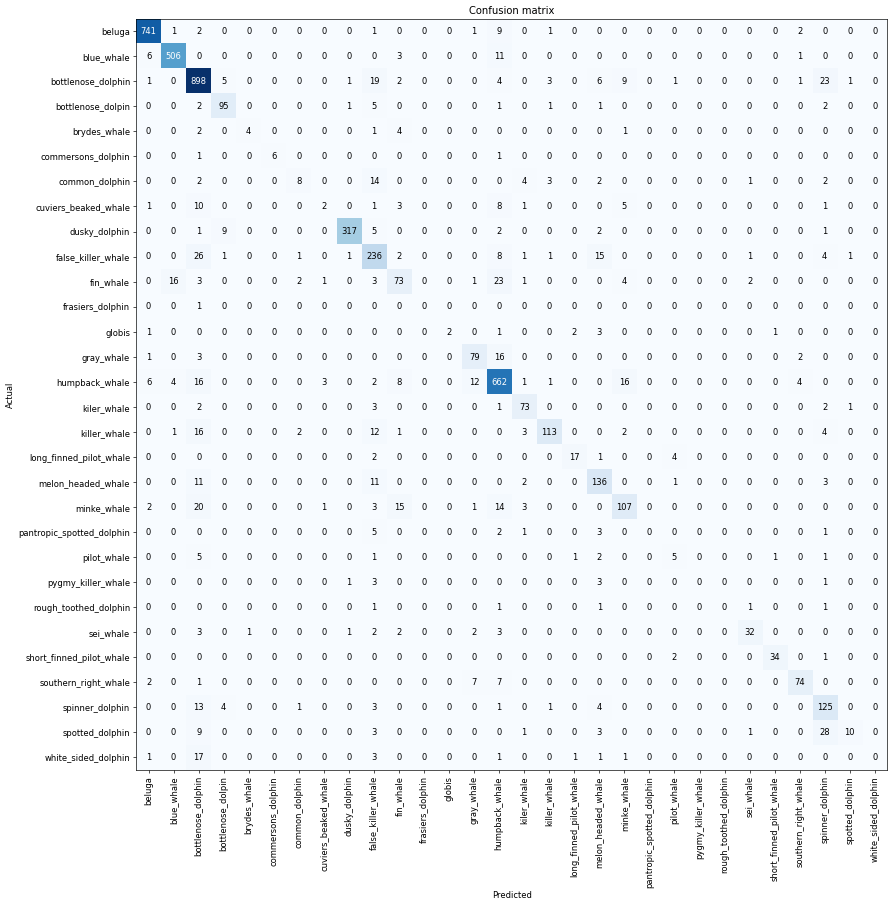

In [38]:
interp_pretrained.plot_confusion_matrix(figsize=(15,15), dpi=60)

In [39]:
interp_pretrained.most_confused(min_val=20)

[('spotted_dolphin', 'spinner_dolphin', 28),
 ('false_killer_whale', 'bottlenose_dolphin', 26),
 ('bottlenose_dolphin', 'spinner_dolphin', 23),
 ('fin_whale', 'humpback_whale', 23),
 ('minke_whale', 'bottlenose_dolphin', 20)]

## Results

The pretrained `resnet34` gives results that are comparable with the untrained `xresnet34`. Unexpectedly, when the former is unfrozen and then retrained, the results are worse than in the latter case. I have given an explanation on why that happens: basically, the pretrained model might grasping some characteristic features of the individuals that are then not recognised later when unfreezing. I will investigate it at some point, but at the moment I have no time. Together with that, I could try using a `resnet50` or `xresnet50` although the results were already above 90%.

Also, the competition was demanding the ability to recognise single individuals, which is something that I need to spend more time (and Colab resources) on.